In [1]:
import sys

sys.path.append(r"C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\IRSource\Logger")
sys.path.append(r"C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\IRSource\DAQ")
sys.path.append(r'C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\IRSource\Logger\logs\sessions')
sys.path.append(r'C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\IRSource\Exceptions')
sys.path.append(r'C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\IRSource\API')
sys.path.append(r'C:\Users\oper\SynologyDrive\Lab2023\KIDs\QTLab2324\IRSource\API\SingleFreq')

import json
from DAQ import DAQ
from Acquisition_config import ACQUISITION_CONFIG
import logging
from logging.config import dictConfig
from SingleFreq.logs.logging_config import LOGGING_CONFIG 
from Exceptions import replace_non_serializable
from PAmodules.QuickSyn import FSL_0010
from PAmodules.network.RS_Signal_Generator import RS_SMA100B
import numpy as np
import niscope as ni
from PAmodules import Tools
from HDF5 import HDF5 as h5
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [2]:
import pyvisa
ind = pyvisa.ResourceManager().list_resources()
print(ind)

('ASRL1::INSTR', 'ASRL10::INSTR', 'ASRL31::INSTR', 'ASRL35::INSTR', 'ASRL36::INSTR', 'ASRL40::INSTR')


In [3]:

ip   = '192.168.40.15'   # Set IP address of SMA
devicename = 'PXI1Slot3' 
filepath = r'C:\\Users\\oper\\SynologyDrive\\Lab2023\\KIDs\\QTLab2324\\IRSource\\API\\SingleFreq\\png\\'

#===============================================================================================
#Import logger configuration
#===============================================================================================
dictConfig(LOGGING_CONFIG)
logger = logging.getLogger(__name__)
logger.info('START EXECUTION')

try:
    cfg1 = json.dumps(replace_non_serializable(ACQUISITION_CONFIG))
    logger.info('Dumping acquisition configuration')
    with open(ACQUISITION_CONFIG['acq_conf']['path'] + 'config.json','w') as f:
        f.write(cfg1)
except Exception:
    logger.critical('Dumping acquisition configuration')
    raise SystemError("Could not dump acquisition configuration!")

#===============================================================================================
#Acquire DAQ configuration dictionaries
#===============================================================================================

try:
    daq = DAQ()
    logger.info('DAQ class object correctly created')
except Exception:
    logger.critical('Could not crate DAQ class object')
    raise SyntaxError('Could not create DAQ class object')

try:
    fsl = FSL_0010.FSL10_synthesizer(device_address='COM31')
    logger.info('FSL_0010 class object correctly created')
except Exception:
    logger.critical('Could not crate FSL class object')
    raise SyntaxError('Could not create FSL class object')

try:
    sGen = RS_SMA100B.SMA100B(ip)
    logger.info('SMA class object correctly created')
except Exception:
    logger.critical('Could not crate SMA class object')
    raise SyntaxError('Could not create SMA class object')

16:47:41.415 - __main__ - <module> - INFO - START EXECUTION
16:47:41.417 - __main__ - <module> - INFO - Dumping acquisition configuration
16:47:41.420 - __main__ - <module> - INFO - DAQ class object correctly created
16:47:41.431 - __main__ - <module> - INFO - FSL_0010 class object correctly created
SMA100B: Connection successful!
16:47:41.456 - __main__ - <module> - INFO - SMA class object correctly created


In [16]:
LO =  7e9 
RF     = LO + 4e6
amplitude       = 13  
sample_rate     = 250e6
k               = 4
pulse_period    = k * 1e-6
num_points      = int(sample_rate * pulse_period)
percent         = 2
pulse_width     = pulse_period * (1-percent/100)
pulse_delay     = 0

channels = {'I'			: 0, 
            'Q'			: 1,
            'trigger'	: 3}

In [17]:
try:    
    sGen.reset()
    sGen.clear()
    sGen.pul_gen_params(delay = pulse_delay, width = pulse_width, period = pulse_period)  
    #sGen.pul_gen_mode('SING')
    #sGen.pul_trig_mode('SING')
    sGen.RF_lvl_ampl(amplitude)
    logger.info('SMA set up correctly')
except Exception:
    logger.critical('Could not set up SMA')
    raise SystemError('Could not create SMA class object')


try:
    stat = daq.get_status
    logger.info('DAQ status: '+str(stat))
except Exception:
    logger.critical('Could not get DAQ status!')
    raise SystemError('Could not get DAQ status')

16:48:01.896 - __main__ - <module> - INFO - SMA set up correctly
16:48:01.897 - __main__ - <module> - INFO - DAQ status: <bound method DAQ.get_status of <DAQ.DAQ object at 0x0000000018D21580>>


In [18]:
try:
    daq.acq_conf = ACQUISITION_CONFIG['acq_conf']
    logger.info('Inserting acquisition configuration from ACQUISITION_CONFIG dictionary')
except Exception:
    logger.warning('Coulkd not insert acquisition configuration')
    raise SystemError('Coulkd not insert acquisition configuration')

try:
    daq.horizontal_conf = ACQUISITION_CONFIG['horizontal']
    logger.info('Inserting hconf dic')
except Exception:
    logger.warning('Could not insert hconf dic')
    raise SystemError('Could not insert hconf dic')

try:
    daq.vertical_conf = ACQUISITION_CONFIG['vertical']
    logger.info('Inserting vconf dic')
except Exception:
    logger.warning('Could not insert vconf dic')
    raise SystemError('Could not insert vconf dic')

try:
    daq.chan_conf = ACQUISITION_CONFIG['chan_conf']
    logger.info('Inserting chan char dic')
except Exception:
    logger.warning('Could not insert chan char dic')
    raise SystemError('Could not insert chan char dic')

try:
    daq.trigger_dic = ACQUISITION_CONFIG['trigger']
    logger.info('Inserting trigger dic')
except Exception:
    logger.warning('Could not insert trigger dic')
    raise SystemError('Could not insert trigger dic')


16:48:01.955 - __main__ - <module> - INFO - Inserting acquisition configuration from ACQUISITION_CONFIG dictionary
16:48:01.957 - __main__ - <module> - INFO - Inserting hconf dic
16:48:01.958 - __main__ - <module> - INFO - Inserting vconf dic
16:48:01.959 - __main__ - <module> - INFO - Inserting chan char dic
16:48:01.960 - __main__ - <module> - INFO - Inserting trigger dic


In [19]:
daq._session = ni.Session(devicename)
try:
    daq.config_trigger()
    logger.info('implementing trigger')
except Exception:
    logger.warning('Could not implement trigger')
    raise SystemError('Could not implement trigger')

16:48:02.199 - __main__ - <module> - INFO - implementing trigger


In [20]:
try:
    logger.info(f'FSL is now outputting signal at {LO} Hz')
    fsl.set_output('ON')
    fsl.set_frequency(int(LO*1e-9)) # GHz
except Exception:
    logger.critical('FSL is not outputting signal!')

#power = round(Tools.dBm_to_mVpk(amplitude))
#logger.info('Setting SMA amplitude')

16:48:02.296 - __main__ - <module> - INFO - FSL is now outputting signal at 7000000000.0 Hz


In [21]:
with daq._session as session:
    logger.info('Configuring channels')
    daq.configure_channels()
    logger.info('Executing trigger')
    sGen.RF_freq(RF) 
    sGen.pul_state(1)
    sGen.RF_state(1)
    data = {'CH0': [],
            'CH1': [],
            'CH2': [],
            'CH3': []}
    wf_info = []
    try:
        daq._session.initiate()
        logger.info('Session initiated')
    except Exception:
        logger.critical('Could not initiate session')
    try:
        logger.info('Initiating fetching...')
        waveforms = session.channels[0,1].fetch()
    except Exception:
        logger.error('Could not fetch!!')
        sys.exit()

16:48:02.570 - __main__ - <module> - INFO - Configuring channels
16:48:02.572 - __main__ - <module> - INFO - Executing trigger
16:48:02.608 - __main__ - <module> - INFO - Session initiated
16:48:02.609 - __main__ - <module> - INFO - Initiating fetching...


In [22]:
Q_list, I_list = [], []
for wfm in waveforms:
    if wfm.channel == '0':
        I_list.append(wfm.samples.tolist())
    else:
        Q_list.append(wfm.samples.tolist())

In [23]:
print(len(waveforms[0].samples.tolist()))

1000


In [61]:
from scipy import constants as cns
P = 1.5*1e-3
DT = 1/1.6 * 1e-9
f = cns.c/(1550 * 1e-9)
E = cns.h * f
print(1/3*((P * DT)/E)*1e-6)


2.4384002124035


In [47]:
from scipy import special as sp
core_diam = 8.2*1e-6 # meters
lenght = 1 # meters
lam = 1555 * 1e-9 #meters

def airy(theta):
    a=core_diam
    k = 2*np.pi/lam
    x = k*a*np.sin(theta)
    return (2*sp.j1(x)/x)**2

C:\Users\oper\AppData\Local\Temp\ipykernel_8756\1324559994.py:10: RuntimeWarning: invalid value encountered in divide
  return (2*sp.j1(x)/x)**2


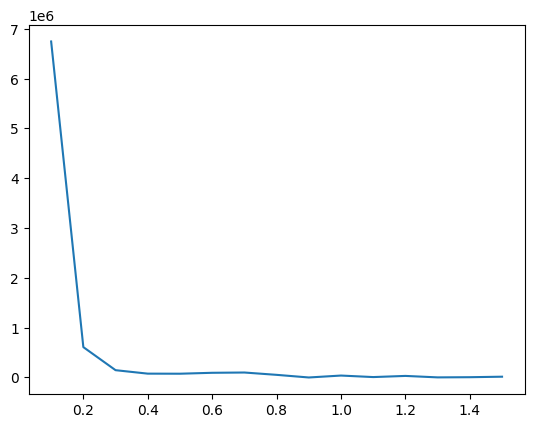

In [58]:
theta = np.arange(0,np.pi/2,0.1)
plt.plot(theta,out*airy(theta))


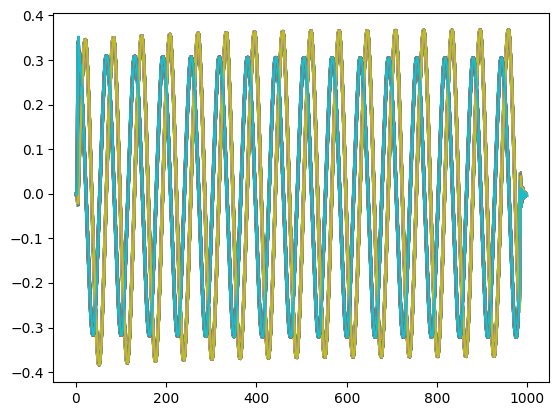

In [24]:
x = np.arange(0,len(waveforms[0].samples.tolist()),1)
for i,q in zip(I_list,Q_list):
    plt.plot(x,i)
    plt.plot(x,q)
    #plt.xlim([500,550])


(950.0, 1050.0)

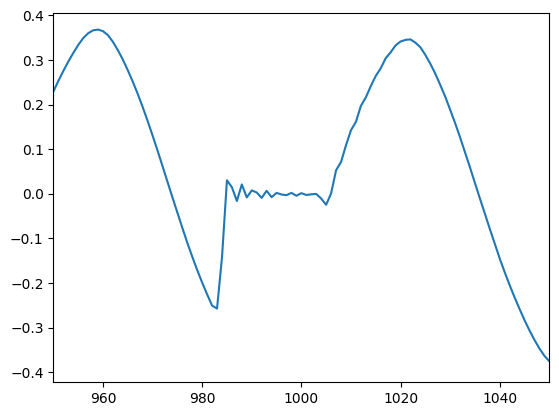

In [28]:
plt.plot(I_list[0]+I_list[1])
plt.xlim([950,1050])

In [13]:

try:
    hdf5 = h5.HDF5()
    path = r'C:\\Users\\oper\\SynologyDrive\\Lab2023\\KIDs\\QTLab2324\\IRSource\\API\\SingleFreq\\files\\'
    hdf5.name = 'Mixer1237.hdf5'
    hdf5.dic = data
    hdf5.to_hdf5()
    logger.info('Transfering data from python dic to '+str(path+hdf5.name))
except Exception:
    logger.warning('Could not transfer data into '+str(path+hdf5.name))

Execution time: 0.005
16:47:47.189 - __main__ - <module> - INFO - Transfering data from python dic to C:\\Users\\oper\\SynologyDrive\\Lab2023\\KIDs\\QTLab2324\\IRSource\\API\\SingleFreq\\files\\Mixer1237.hdf5


Raw data plot

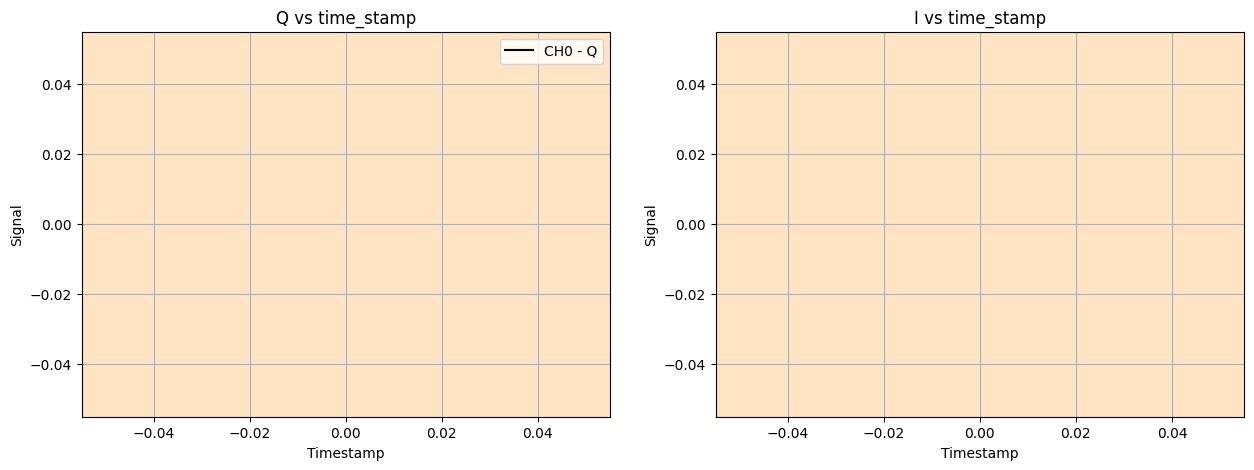

In [25]:
fig, axs = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
axs[0].plot(np.arange(len(data['CH0']))/sample_rate, data['CH0'], color='black', label='CH0 - Q')
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Signal')
axs[0].set_title('Q vs time_stamp')
axs[0].set_facecolor('bisque')
axs[0].legend()
axs[0].grid()
axs[1].plot(np.arange(len(data['CH1']))/sample_rate, data['CH1'], color='black', label='CH1 - I')
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Signal')
axs[1].set_title('I vs time_stamp')
axs[1].set_facecolor('bisque')
axs[1].grid()

In [15]:
Q_max, Q_dic = find_peaks(data['CH0'], height=max(data['CH0']*6/10), threshold=None, distance=50)
I_max, I_dic = find_peaks(data['CH1'], height=max(data['CH1']*6/10), threshold=None, distance=50)

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [ ]:
data['CH0'] = data['CH0'][:Q_max[-1]]
data['CH1'] = data['CH1'][:I_max[-1]]

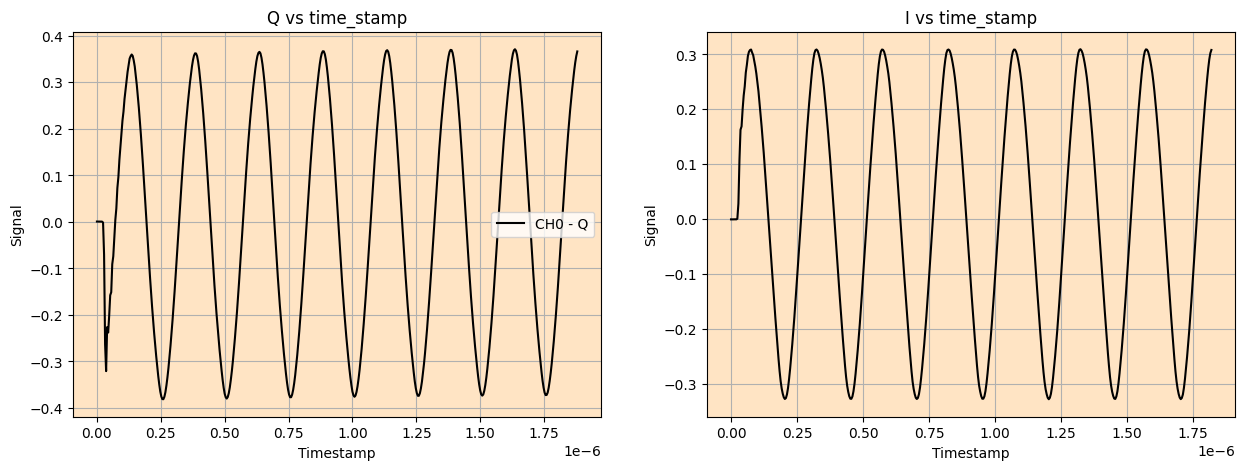

In [ ]:
fig, axs = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
axs[0].plot(np.arange(len(data['CH0']))/sample_rate, data['CH0'], color='black', label='CH0 - Q')
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Signal')
axs[0].set_title('Q vs time_stamp')
axs[0].set_facecolor('bisque')
axs[0].legend()
axs[0].grid()
axs[1].plot(np.arange(len(data['CH1']))/sample_rate, data['CH1'], color='black', label='CH1 - I')
axs[1].set_xlabel('Timestamp')
axs[1].set_ylabel('Signal')
axs[1].set_title('I vs time_stamp')
axs[1].set_facecolor('bisque')
axs[1].grid()


In [ ]:
if len(data['CH1'])<len(data['CH0']):
    idx = [i for i,_ in enumerate(data['CH1'])]
    data['CH0'] = [val for (i,val) in zip(idx, data['CH0'])]
else:
    idx = [i for i,_ in enumerate(data['CH0'])]
    data['CH1'] = [val for (i,val) in zip(idx, data['CH1'])]
print(len(data['CH0']))
print(len(data['CH1']))

456
456


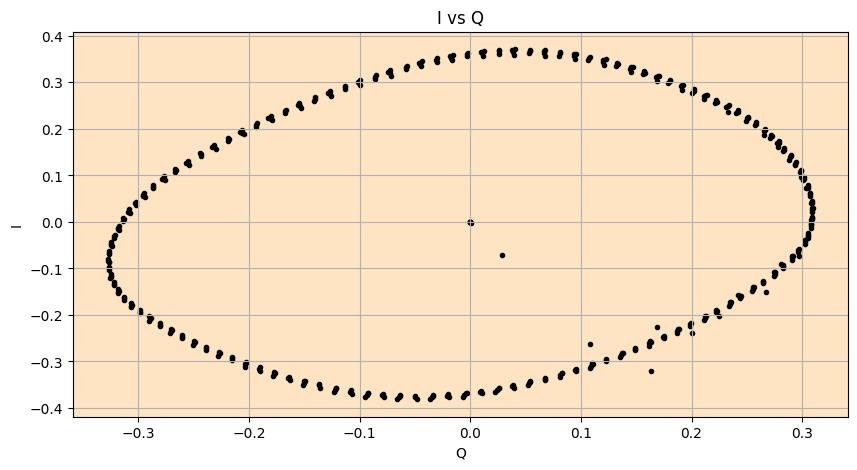

In [ ]:
fig, axs = plt.subplots(1,1)
fig.set_figheight(5)
fig.set_figwidth(10)
axs.scatter(data['CH1'], data['CH0'], marker='.', color='black', label='I vs Q')
axs.set_xlabel('Q')
axs.set_ylabel('I')
axs.set_title('I vs Q')
axs.set_facecolor('bisque')
axs.grid()